In [1]:
import pickle
import networkx as nx
import geopandas as gpd
import shapely
from tqdm import tqdm
from shapely import wkt
import pickle
import osmnx as ox
import pandas as pd
import numpy as np

In [2]:
graph = nx.read_graphml('/Users/polina/Desktop/don/graph_uds_final.graphml')
cities = gpd.read_file('admin_centers_LO_188_polygons_with_UDS_matrix (1).geojson')
dots = gpd.read_file("admin_centers_LO_188_points.geojson")
water = gpd.read_file('water.geojson')
citycrs = cities.crs

In [3]:
# combine city centers and polygons into one gdf

cities = gpd.overlay(cities.to_crs(citycrs), water.to_crs(citycrs), how='difference')
cities['center'] = dots['geometry']
cities = cities.to_crs(citycrs)
cities = cities.set_geometry('center').to_crs(citycrs)

In [ ]:
from dongraphio import DonGraphio,GraphType
import matplotlib.pyplot as plt


# graph_type = 'INTER'/'DRIVE'
# cities must contain a gdf with 'center' column for Point of admin_center and 'geometry' for polygons of admin territories

def connectivity(graph,cities,graph_type):

    speed = {'bus':60 * 16.6666667,
            'subway': 80* 16.6666667,
            'train':80* 16.6666667,
            'tram':60* 16.6666667,
            'trolleybus':60* 16.6666667,
            'walk':5* 16.6666667,
            'drive':70*16.6666667,
            'car':70*16.6666667
            }
    for e1,e2,data in graph.edges(data=True):
        data['type'] = 'car'
        data['time_min'] = float(data['length_meter'])/speed[data['type']]
        data['geometry'] = wkt.loads(data['geometry'])


    def convert_node_names_to_int(graph):
        node_mapping = {node: int(node) for node in graph.nodes()}
        G_int = nx.relabel_nodes(graph, node_mapping)
        return G_int

    graph = convert_node_names_to_int(graph)


    dg = DonGraphio(cities.crs.to_epsg())
    dg.set_graph(graph)
    if graph_type =='INTER':
        adj_mx = dg.get_adjacency_matrix(cities,cities, weight='time_min', graph_type=[GraphType.WALK, GraphType.PUBLIC_TRANSPORT])
    else:
        adj_mx = dg.get_adjacency_matrix(cities, cities, weight='time_min', graph_type=[GraphType.DRIVE])

    medians = []
    for index, row in adj_mx.iterrows():
        median = np.median(row[row.index != index])  # Exclude diagonal component
        medians.append(median)

    median_df = pd.DataFrame({'Median': medians})
    cities['adj_h'] = median_df/60
    cities.set_geometry('geometry',inplace=True)

    cmap = 'RdYlGn_r'
    ax = cities.plot(column='adj_h', cmap=cmap, figsize=(16, 8), legend=True)
    ax.set_axis_off()
    if graph_type =='INTER':
        plt.title('Транспортная связность по графу ОТ, час')    
    else:
        plt.title('Транспортная связность по графу УДС, час')
    plt.title('Транспортная связность по графу УДС, час')
    plt.savefig('uds_connectivity.png', dpi=600)
    plt.show()
    
    return adj_mx


2024-05-13 09:58:50.387 | INFO     | dongraphio.dongraphio:get_adjacency_matrix:90 - Creating adjacency matrix based on provided graph...
/Users/polina/Desktop/don/myenv10/lib/python3.10/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/polina/Desktop/don/myenv10/lib/python3.10/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
2024-05-13 09:58:58.054 | DEBUG    | dongraphio.base_models.matrix_logic:get_adjacency_matrix:52 - Calculating distances from buildings to services ...
2024-05-13 09:58:59.509 | INFO     | dongraphio.dongraphio:get_adjacency_matrix:99 - Adjacency matrix done!


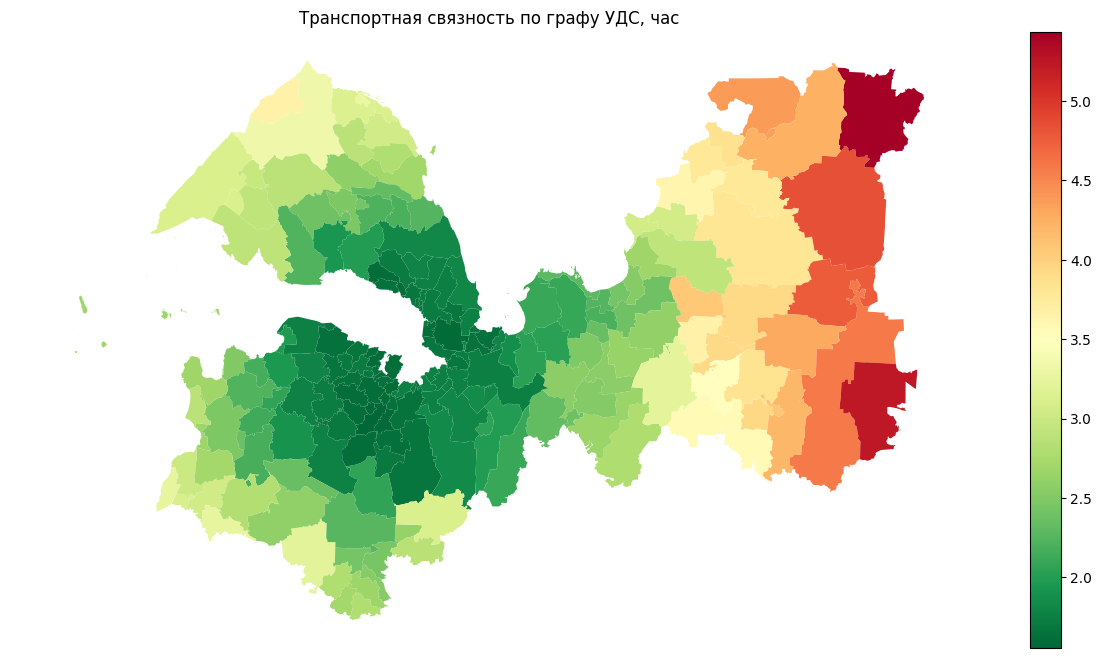

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.000000,227.961069,52.353936,96.418993,149.874794,235.716852,114.836180,229.314849,59.687022,75.657716,...,193.726080,165.794086,96.330160,64.668279,256.686761,100.081784,46.326552,12.898208,194.109023,227.023521
1,228.059282,0.000000,218.516772,262.581829,134.610403,127.534753,280.959028,121.132749,241.969232,236.837821,...,113.100617,331.956922,196.761147,168.973894,86.797622,135.273674,193.353738,218.576642,356.387988,42.714363
2,54.001303,218.646626,0.000000,49.717047,140.560351,226.402410,68.469323,220.000406,30.545473,34.066341,...,184.411637,119.092141,71.554677,55.353836,247.372318,90.767342,48.358832,42.581140,152.080109,217.709078
3,97.929330,262.574653,49.726808,0.000000,184.488378,270.330437,25.627248,263.928433,47.741522,45.311008,...,228.339664,70.775514,106.961675,99.281864,291.300345,134.695369,92.286859,86.509167,151.217431,261.637105
4,150.043011,134.323909,140.500501,184.565558,0.000000,133.398021,195.932300,126.996018,163.952961,151.811094,...,91.407248,253.940651,94.865571,90.957623,154.367929,57.257403,115.337467,140.560371,263.228335,133.386361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,100.899453,135.252553,91.356944,135.422000,57.166279,143.008337,153.799199,136.606333,114.809403,109.677992,...,101.017564,204.797094,69.601318,41.814065,163.978245,0.000000,66.193909,91.416813,229.228159,134.315005
184,43.508936,192.893934,48.899998,92.965055,114.807660,200.649718,111.382243,194.247714,72.352458,69.793772,...,158.658945,162.340148,61.263026,29.601145,221.619626,65.014650,0.000000,34.026296,188.245078,191.956386
185,12.898208,219.978946,42.024305,86.089362,141.892671,227.734729,104.506550,221.332726,48.266859,65.328086,...,185.743956,155.464455,87.168326,56.686156,248.704638,92.099661,38.344429,0.000000,183.779392,219.041398
186,195.254387,355.406182,152.113672,150.927846,263.086375,348.702984,145.519273,342.300981,172.465975,120.435792,...,309.314585,177.459781,175.389782,193.926444,377.739319,227.526898,187.025044,183.834224,0.000000,354.468634


In [6]:
connectivity(graph,cities,'DRIVE')